In [1]:
#5-fold cross validation
# Run GBT classifier with cross-validation and plot ROC curves
import numpy as np
import pandas as pd
from functools import reduce

from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import interp 
from itertools import cycle

import matplotlib.pyplot as plt

In [2]:
# Download data files from paper's repo at https://github.com/ShenLab/A-risk/tree/master/data
DO_DOWNLOAD_FILES = True

if DO_DOWNLOAD_FILES:
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/celltype%3E10cells_fraction_LM_noUnk.csv 
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/celltype%3E10cells_fraction_zhong.csv
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/control_genes_1911_iossifov.csv
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/fraction_expression_Hodge2019.csv
  !wget --quiet https://raw.githubusercontent.com/ShenLab/A-risk/master/data/sfari_high_confidence_genes_08292019.csv

In [3]:
#load data
lm = pd.read_csv("celltype>10cells_fraction_LM_noUnk.csv", index_col=0)
zhong = pd.read_csv("celltype>10cells_fraction_zhong.csv", index_col=0)

In [4]:
df_merged = [lm, zhong]
data = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True, how='inner'), df_merged)

In [6]:
autism_gene = pd.read_csv("sfari_high_confidence_genes_08292019.csv", index_col=0)
control_gene = pd.read_csv("control_genes_1911_iossifov.csv", index_col=0)

In [7]:
autism = data.loc[data.index.intersection(autism_gene['gene.symbol']),]
autism.shape

(88, 95)

In [8]:
control = data.loc[data.index.intersection(control_gene['GeneName']), ]
control.shape

(156, 95)

In [9]:
autism.index.intersection(control.index)

Index(['KDM5B', 'CACNA1H'], dtype='object')

In [10]:
control = control.drop(['CACNA1H', ])
control = control.drop(['KDM5B', ])
control.shape

(154, 95)

In [11]:
combine = [autism, control]
combine = pd.concat(combine)
combine.shape

(242, 95)

In [12]:
prelabel = np.array([1,0])
label = pd.DataFrame({'labels': np.repeat(prelabel, [autism.shape[0], control.shape[0]], axis = 0)})
label.shape

(242, 1)

In [13]:
index = np.random.permutation(label.index)
combine = combine.iloc[index]
label = label.iloc[index]

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/tmp/ipykernel_194/4134823524.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/tmp/ipykernel_194/4134823524.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ortable['probas_'] = probas_[:,[1]]
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

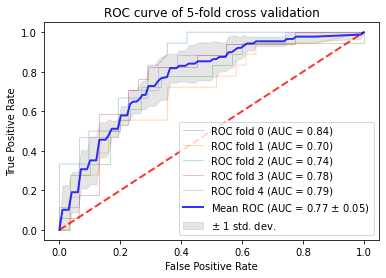

In [14]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
pre_df = pd.DataFrame(index = data.index)
oddsratio_df = pd.DataFrame(index = np.arange(0.0,1.05,0.05))
fi_df = pd.DataFrame()
for train, test in cv.split(combine, label):
    params = {'n_estimators': 300,'learning_rate': 0.05, 'max_depth':1, 'random_state':2019}
    clf = GradientBoostingClassifier(**params).fit(combine.iloc[train], label.iloc[train])
    #print(combine.ix[test])
    
    probas_ = clf.predict_proba(combine.iloc[test])
    #print probas_
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(label.iloc[test], probas_[:,[1]])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    #calculate odds ratio
    ortable = label.iloc[test]
    ortable['probas_'] = probas_[:,[1]]
    oddsratios = []
    for j in np.arange(0.0,1.05,0.05):
        upthreshold = ortable[ortable['probas_'] >= j]
        x1 = float(sum(upthreshold['labels'] == 1)+1)
        x0 = float(sum(upthreshold['labels'] == 0)+1)
        
        downthreshold = ortable[ortable['probas_'] < j]
        y1 = float(sum(downthreshold['labels'] == 1)+1)
        y0 = float(sum(downthreshold['labels'] == 0)+1)
        
        oddsratio = (x1/y1)/(x0/y0)
        oddsratios.append(oddsratio)
    oddsratio_df.insert(value = oddsratios, column = i, loc = 0)
    
    prediction = clf.predict_proba(data)
    pre_df.insert(value= prediction[:,[1]], column= i, loc=0)
    
    fi = clf.feature_importances_
    fi_df.insert(value= fi, column = i, loc = 0)

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of 5-fold cross validation')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('../plot/ROC_filteredCellNumber_LMZhong_fracE_classifier_average_08292019sfari.pdf', bbox_inches = 'tight')

In [19]:
#plot feature importance that are not zero
feature_importance = fi_df.mean(axis=1)
# make importances relative to max importance
#feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance) #Returns the indices that would sort an array
sorted_idx = sorted_idx[np.array(feature_importance[sorted_idx] != 0)]

In [20]:
sorted_idx.shape

(67,)

In [21]:
pos = np.arange(0,sorted_idx.shape[0]*3, 3) + .5
pos.shape

(67,)

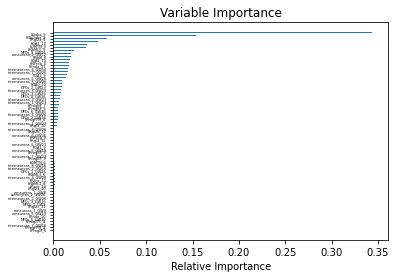

In [22]:
plt.tick_params(axis = "y", labelsize = 3.5)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, combine.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [23]:
feature_importance_sele = pd.DataFrame({'celltypes': combine.columns[sorted_idx], 'importance': feature_importance[sorted_idx]})
feature_importance_sele

,celltypes,importance
33,hProgM_6,0.000192
44,hProgFPM_8,0.000192
87,interneurons_7_GW16,0.000192
43,hProgFPL_8,0.000343
76,NPCs_6_GW10,0.000398
...,...,...
6,hOMTN_9,0.035896
21,hDA1_10,0.047735
3,hRgl2a_9,0.058088
13,hNbGaba_9,0.154181


In [25]:
feature_importance_sele.to_csv('feature_importance_filteredCellNumber_LMZhong_fracE_filtergene_zhong_classifier_average_noUnk_08292019sfari.csv')

In [26]:
pre_prob = pd.DataFrame(pre_df.mean(axis=1))

pre_prob['Batch'] = 'testing'
pre_prob.loc[autism.index,'Batch'] = 'autism'
pre_prob.loc[control.index,'Batch'] = 'control'

pre_prob.rename(columns={0 : 'Frisk'}, inplace=True)
pre_prob

,Frisk,Batch
DDX11L1,0.065435,testing
LOC101928626,0.107505,testing
LINC00115,0.108803,testing
LINC01128,0.232370,testing
FAM41C,0.126594,testing
...,...,...
TTTY14,0.076814,testing
CD24,0.592469,testing
KDM5D,0.110313,testing
EIF1AY,0.110316,testing


In [28]:
pre_prob.to_csv('prediction_allGenes_GBT_filteredCellNumber_LMZhong_fracE_classifier_average_noUnk_08292019sfari.csv')